In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import model, train, metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
writer = SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [6]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


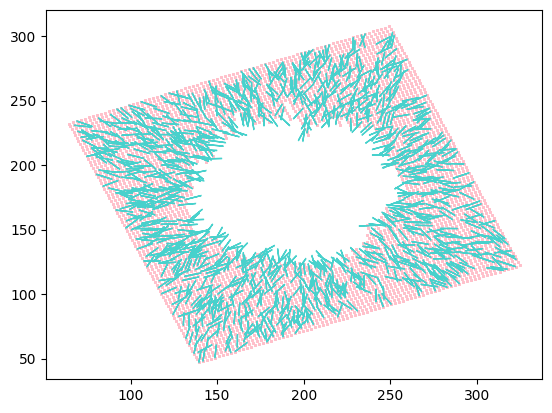

In [8]:
plotter.plot_train_data(train_data)

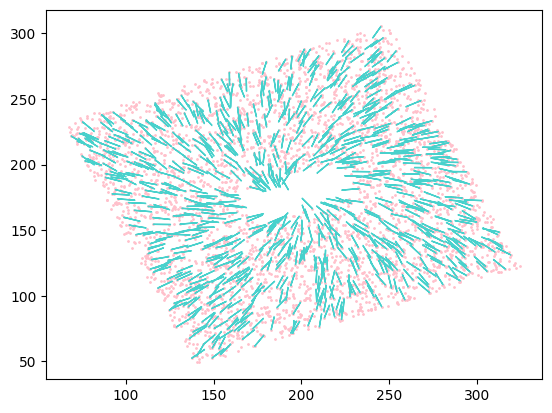

In [9]:
plotter.plot_data(val_data)

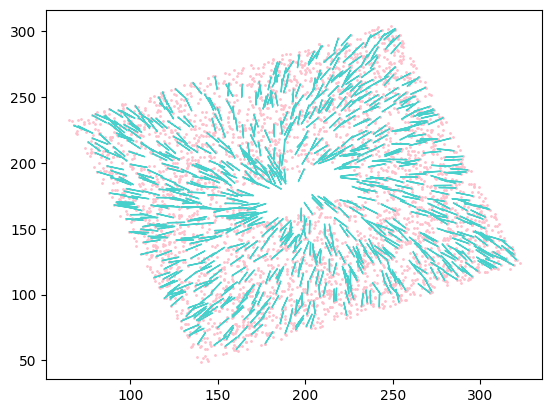

In [10]:
plotter.plot_data(test_data)

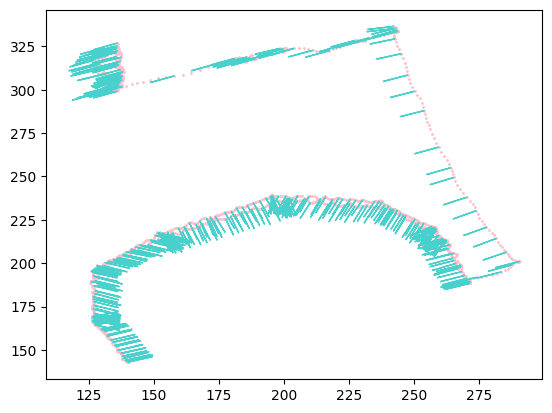

In [11]:
plotter.plot_data(real_data)

In [12]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


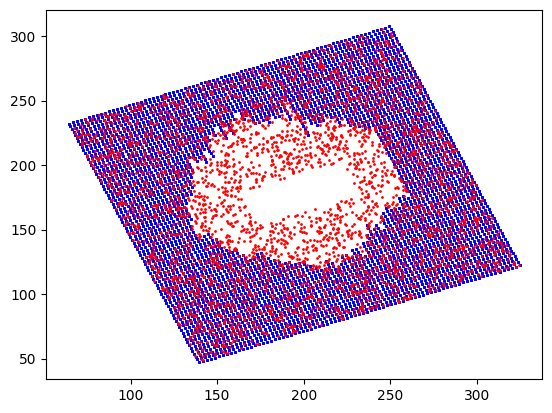

In [13]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2133.84it/s]


Validation after filtering: 3253


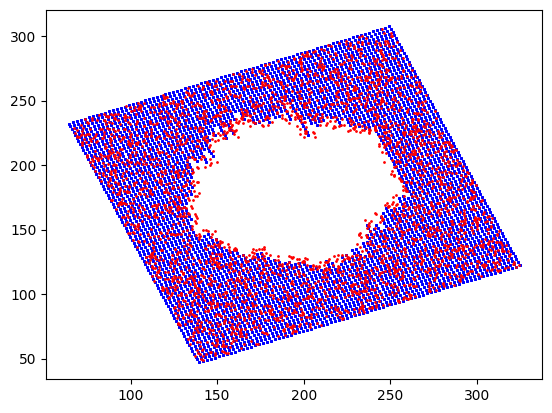

In [14]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


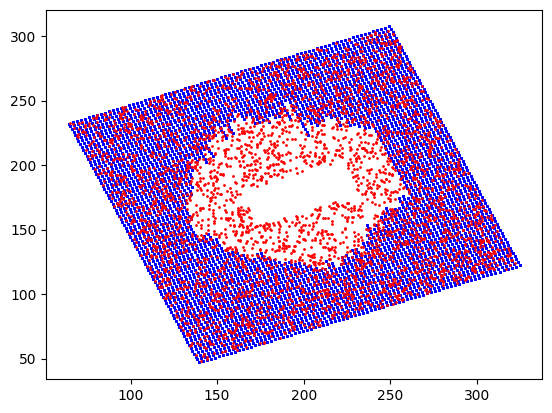

In [15]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2028.02it/s]


Test after filtering: 3271


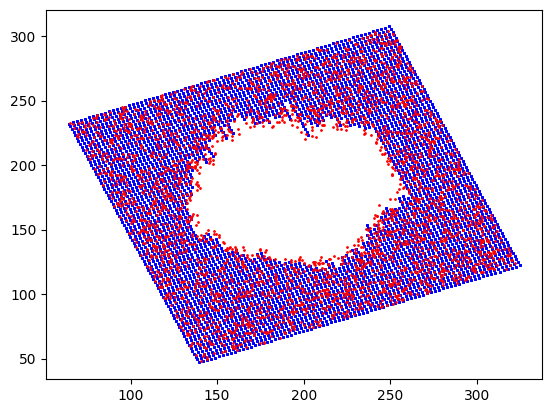

In [16]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

dist matrix tensor([0.7955, 0.7955, 0.7955, 0.7955, 0.7955])
cand tensor([ 65.4292,  80.4292,  95.4292, 110.4292,  50.4292])
yaw_deg 87.79165
diff yaw tensor([22.3624,  7.3624,  7.6376, 22.6376, 37.3625])
iou: 0.918941337356393
yaw difference tensor(7.3624) deg
localization error:  0.07902455 meters


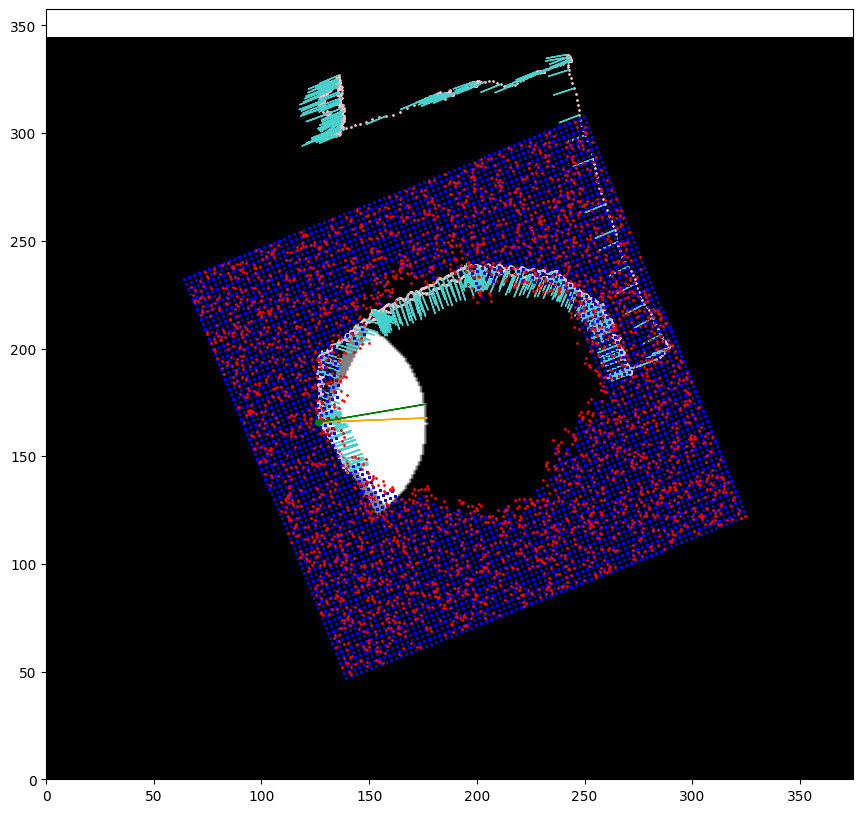

<Figure size 640x480 with 0 Axes>

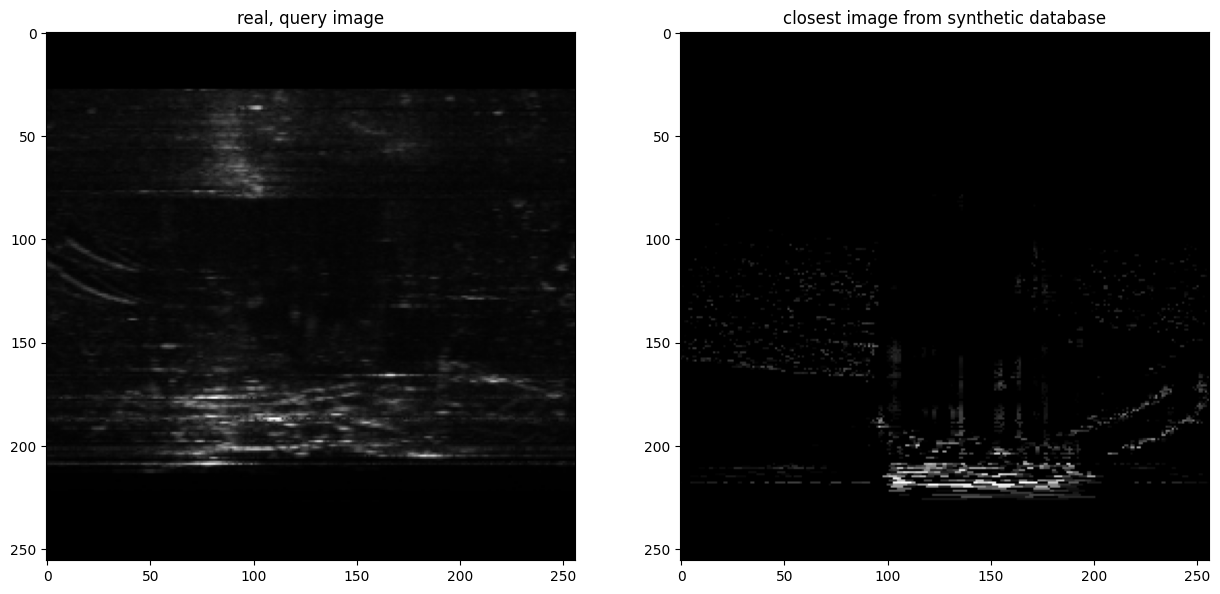

In [17]:
visualizer.localization(train_data, val_data, real_data)

In [18]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [19]:
val_data = visualizer.check_gt(train_data, val_data)

In [20]:
test_data = visualizer.check_gt(train_data, test_data)

In [21]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3250
Test: 3269


In [22]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [23]:
net = model.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [24]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [25]:
train.train_epochs(writer, train_data, train_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)

  0%|                                          | 4/1501 [00:04<30:58,  1.24s/it]


KeyboardInterrupt: 

In [26]:
metrics.get_descriptors(train_data, val_data, net)

  1%|▎                                      | 185/24005 [00:02<04:26, 89.50it/s]


KeyboardInterrupt: 

## Visualize Training results on Validation data

### Load the checkpoint model

In [27]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model.Model()
model.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [28]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  1%|▎                                      | 185/24005 [00:01<04:14, 93.66it/s]


KeyboardInterrupt: 

In [29]:
val_data.computeDescriptors(net)

computing dataset descriptors


  5%|█▉                                      | 156/3250 [00:01<00:34, 90.49it/s]


KeyboardInterrupt: 

### Visualize query results: sonar images

In [30]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-7.8423, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.7425, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4682, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.2117, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5234, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4881, device='cuda:0', grad_fn=<MaxBackward1>)


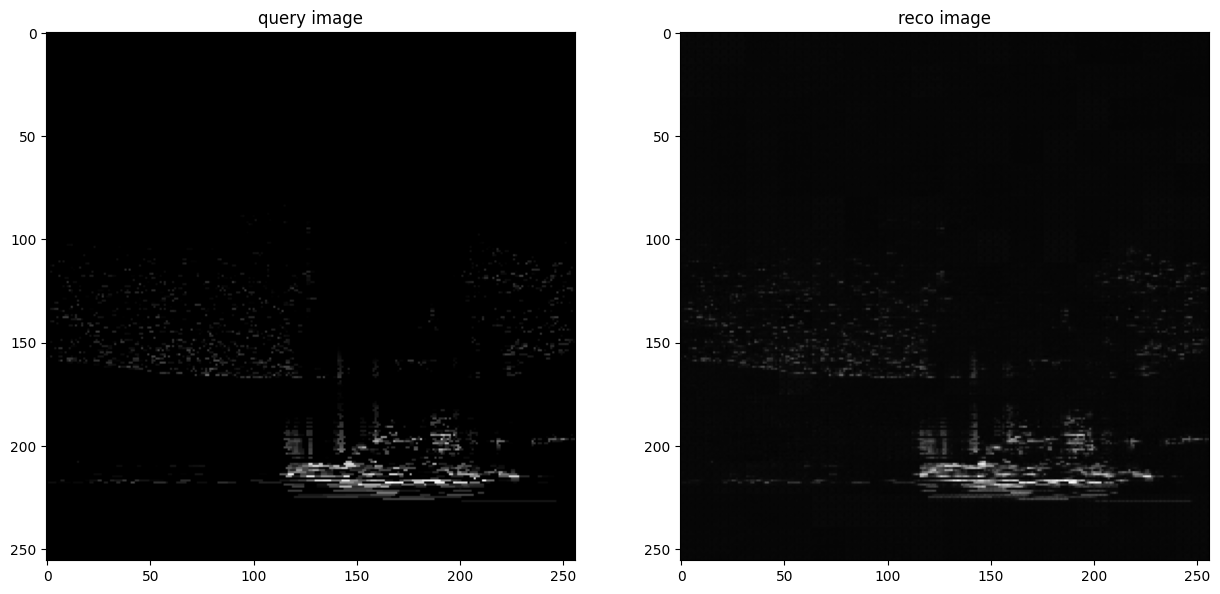

In [31]:
visualizer.analyze_feature_robustness(train_data, net)

dist matrix tensor([1.0496, 1.0496, 1.0496, 1.0496, 1.0496])
cand tensor([340.7791,  25.7791, 325.7791, 355.7791,  10.7791])
yaw_deg 10.651649475097656
diff yaw tensor([29.8726, 15.1274, 44.8726, 14.8726,  0.1274])
iou: 0.05461400423509398
localization error: 6.1745 meters
orientation error : 49.3083 degrees


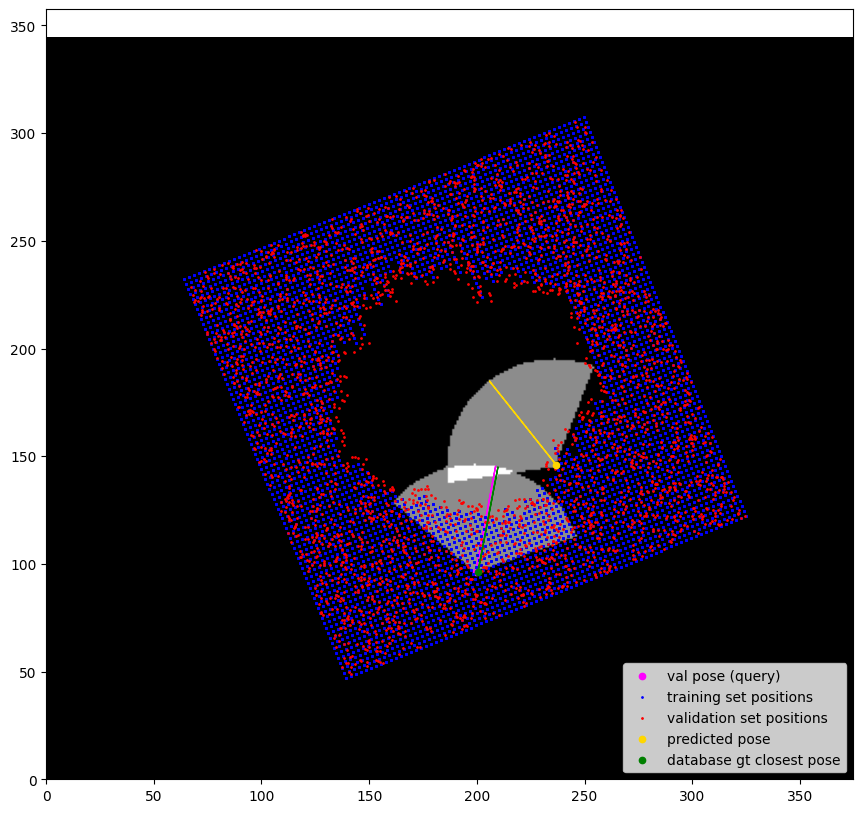

<Figure size 640x480 with 0 Axes>

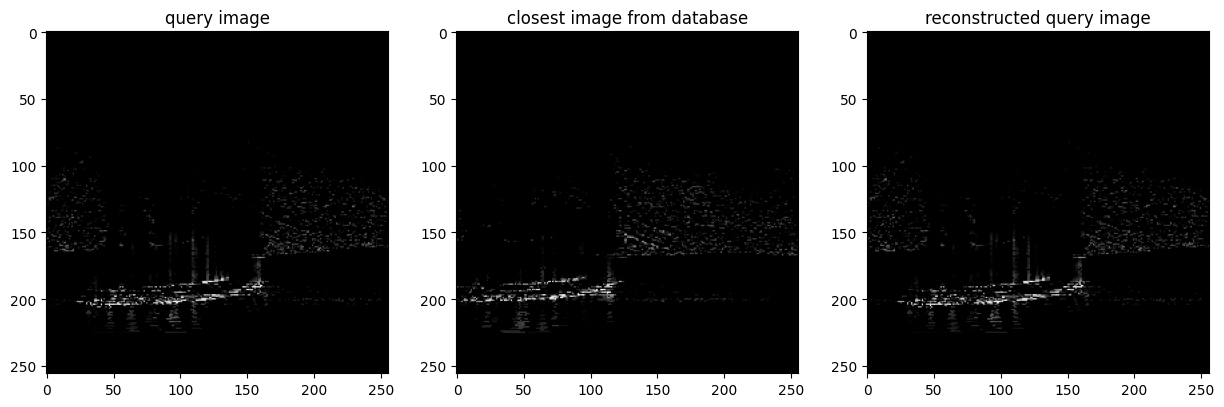

In [32]:
query_idx = random.randint(0, len(val_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [34]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(val_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  0%|                                          | 8/3250 [00:00<01:25, 37.84it/s]

dist matrix tensor([0.8478, 0.8478, 0.8478, 0.8478, 0.8478])
cand tensor([110.6978,  95.6978, 125.6978,  80.6978, 140.6978])
yaw_deg 118.91775321960449
diff yaw tensor([ 8.2200, 23.2200,  6.7800, 38.2200, 21.7800])
dist matrix tensor([0.9186, 0.9186, 0.9186, 0.9186, 0.9186])
cand tensor([228.9039, 273.9039, 288.9039, 243.9039, 258.9039])
yaw_deg 266.95228576660156
diff yaw tensor([38.0483,  6.9517, 21.9517, 23.0483,  8.0483])
dist matrix tensor([1.0897, 1.0897, 1.0897, 1.0897, 1.0897])
cand tensor([321.1105, 351.1105, 336.1105,   6.1105, 306.1105])
yaw_deg 345.6615219116211
diff yaw tensor([24.5511,  5.4489,  9.5511, 20.4489, 39.5511])
dist matrix tensor([3.0568, 3.0568, 3.0568, 3.0568, 3.0568])
cand tensor([183.5017, 123.5017, 153.5017, 138.5017, 168.5017])
yaw_deg 159.29523468017578
diff yaw tensor([24.2065, 35.7935,  5.7935, 20.7935,  9.2065])
dist matrix tensor([0.3953, 0.3953, 0.3953, 0.3953, 0.3953])
cand tensor([247.2497, 217.2497, 202.2497, 187.2497, 232.2497])
yaw_deg 242.2429

  1%|▏                                        | 17/3250 [00:00<01:22, 39.26it/s]

dist matrix tensor([0.3853, 0.3853, 0.3853, 0.3853, 0.3853])
cand tensor([61.3990, 76.3990, 16.3990, 46.3990, 31.3990])
yaw_deg 75.02632141113281
diff yaw tensor([13.6274,  1.3726, 58.6274, 28.6274, 43.6274])
dist matrix tensor([0.4507, 0.4507, 0.4507, 0.4507, 0.4507])
cand tensor([130.9243,  70.9243, 115.9243, 100.9243,  85.9243])
yaw_deg 117.56442642211914
diff yaw tensor([13.3598, 46.6402,  1.6402, 16.6402, 31.6402])
dist matrix tensor([0.5590, 0.5590, 0.5590, 0.5590, 0.5590])
cand tensor([285.4242, 315.4242, 300.4242, 270.4242, 330.4242])
yaw_deg 312.79551696777344
diff yaw tensor([27.3713,  2.6287, 12.3713, 42.3713, 17.6287])
dist matrix tensor([1.2055, 1.2055, 1.2055, 1.2055, 1.2055])
cand tensor([295.4260, 265.4260, 250.4259, 235.4259, 280.4260])
yaw_deg 285.49778747558594
diff yaw tensor([ 9.9282, 20.0718, 35.0719, 50.0719,  5.0718])
dist matrix tensor([1.0607, 1.0607, 1.0607, 1.0607, 1.0607])
cand tensor([171.2157, 186.2157, 141.2157, 126.2157, 156.2157])
yaw_deg 181.197692871

  1%|▎                                        | 22/3250 [00:00<01:20, 39.89it/s]

dist matrix tensor([1.4948, 1.4948, 1.4948, 1.4948, 1.4948])
cand tensor([156.3929, 186.3929, 171.3929, 126.3930, 141.3929])
yaw_deg 173.4472885131836
diff yaw tensor([17.0544, 12.9456,  2.0544, 47.0543, 32.0544])
dist matrix tensor([1.3807, 1.3807, 1.3807, 1.3807, 1.3807])
cand tensor([306.1105, 276.1105, 261.1105, 291.1105, 321.1105])
yaw_deg 315.9891815185547
diff yaw tensor([ 9.8787, 39.8787, 54.8787, 24.8787,  5.1213])
dist matrix tensor([1.1075, 1.1075, 1.1075, 1.1075, 1.1075])
cand tensor([63.6640, 93.6640, 78.6640, 33.6640, 48.6640])
yaw_deg 83.51640939712524
diff yaw tensor([19.8524, 10.1476,  4.8524, 49.8524, 34.8524])
dist matrix tensor([0.6124, 0.6124, 0.6124, 0.6124, 0.6124])
cand tensor([265.6999, 220.6999, 235.6999, 250.6999, 205.6999])
yaw_deg 245.9442138671875
diff yaw tensor([19.7557, 25.2443, 10.2443,  4.7557, 40.2443])
dist matrix tensor([0.8970, 0.8970, 0.8970, 0.8970, 0.8970])
cand tensor([ 78.9821, 138.9821,  93.9821, 108.9821, 123.9821])
yaw_deg 135.877876281738

  1%|▍                                        | 32/3250 [00:00<01:19, 40.67it/s]

dist matrix tensor([0.9437, 0.9437, 0.9437, 0.9437, 0.9437])
cand tensor([212.2049, 197.2049, 152.2049, 182.2049, 167.2049])
yaw_deg 201.65228271484375
diff yaw tensor([10.5526,  4.4474, 49.4473, 19.4474, 34.4474])
dist matrix tensor([1.4307, 1.4307, 1.4307, 1.4307, 1.4307])
cand tensor([303.0013, 273.0013, 258.0013, 318.0013, 288.0013])
yaw_deg 300.4969787597656
diff yaw tensor([ 2.5043, 27.4957, 42.4957, 17.5043, 12.4957])
dist matrix tensor([1.1250, 1.1250, 1.1250, 1.1250, 1.1250])
cand tensor([300.7910, 330.7910, 315.7910, 345.7910, 285.7910])
yaw_deg 334.26195526123047
diff yaw tensor([33.4710,  3.4710, 18.4710, 11.5290, 48.4710])
dist matrix tensor([1.2437, 1.2437, 1.2437, 1.2437, 1.2437])
cand tensor([143.3616, 158.3616, 128.3616, 113.3616,  98.3616])
yaw_deg 150.6040382385254
diff yaw tensor([ 7.2424,  7.7576, 22.2424, 37.2424, 52.2424])
dist matrix tensor([0.4677, 0.4677, 0.4677, 0.4677, 0.4677])
cand tensor([305.2578, 290.2578, 275.2578, 320.2578, 260.2578])
yaw_deg 315.02432

  1%|▌                                        | 42/3250 [00:01<01:16, 41.74it/s]

dist matrix tensor([1.1110, 1.1110, 1.1110, 1.1110, 1.1110])
cand tensor([348.1367,  48.1367,  18.1367,   3.1367,  33.1367])
yaw_deg 36.42959213256836
diff yaw tensor([48.2928, 11.7072, 18.2928, 33.2928,  3.2928])
dist matrix tensor([1.1180, 1.1180, 1.1180, 1.1180, 1.1180])
cand tensor([274.5339, 304.5339, 259.5339, 319.5339, 289.5339])
yaw_deg 317.6616516113281
diff yaw tensor([43.1277, 13.1277, 58.1277,  1.8723, 28.1277])
dist matrix tensor([0.8570, 0.8570, 0.8570, 0.8570, 0.8570])
cand tensor([294.9058, 339.9058, 309.9058, 354.9058, 324.9058])
yaw_deg 354.46788024902344
diff yaw tensor([59.5621, 14.5621, 44.5621,  0.4379, 29.5621])
dist matrix tensor([1.0969, 1.0969, 1.0969, 1.0969, 1.0969])
cand tensor([105.9474, 135.9474,  75.9474, 120.9474,  90.9474])
yaw_deg 133.74647521972656
diff yaw tensor([27.7990,  2.2010, 57.7990, 12.7990, 42.7990])
dist matrix tensor([0.5078, 0.5078, 0.5078, 0.5078, 0.5078])
cand tensor([ 16.8914,   1.8914,  46.8914,  31.8914, 346.8914])
yaw_deg 28.868267

  2%|▋                                        | 52/3250 [00:01<01:18, 40.95it/s]

dist matrix tensor([0.9520, 0.9520, 0.9520, 0.9520, 0.9520])
cand tensor([117.1904, 102.1904, 162.1904, 132.1904, 147.1904])
yaw_deg 151.0194320678711
diff yaw tensor([33.8290, 48.8290, 11.1710, 18.8290,  3.8290])
dist matrix tensor([1.2247, 1.2247, 1.2247, 1.2247, 1.2247])
cand tensor([119.4467,  89.4467, 104.4467, 149.4467, 134.4467])
yaw_deg 137.4764289855957
diff yaw tensor([18.0297, 48.0297, 33.0297, 11.9703,  3.0297])
dist matrix tensor([1.5787, 1.5787, 1.5787, 1.5787, 1.5787])
cand tensor([137.1465,  92.1465, 107.1465, 152.1465, 122.1465])
yaw_deg 133.42332458496094
diff yaw tensor([ 3.7232, 41.2768, 26.2768, 18.7232, 11.2768])
dist matrix tensor([1.3722, 1.3722, 1.3722, 1.3722, 1.3722])
cand tensor([348.8148,  33.8148,  18.8148,  48.8148,   3.8148])
yaw_deg 19.033447265625
diff yaw tensor([30.2187, 14.7813,  0.2187, 29.7813, 15.2187])
dist matrix tensor([1.2562, 1.2562, 1.2562, 1.2562, 1.2562])
cand tensor([246.0790, 261.0790, 291.0790, 276.0790, 306.0790])
yaw_deg 303.42422485

  2%|▊                                        | 62/3250 [00:01<01:16, 41.79it/s]

dist matrix tensor([1.0232, 1.0232, 1.0232, 1.0232, 1.0232])
cand tensor([209.1509, 254.1509, 224.1509, 194.1509, 239.1509])
yaw_deg 224.93614196777344
diff yaw tensor([15.7852, 29.2148,  0.7852, 30.7852, 14.2148])
dist matrix tensor([1.0969, 1.0969, 1.0969, 1.0969, 1.0969])
cand tensor([174.9058, 219.9058, 189.9058, 204.9058, 159.9058])
yaw_deg 216.12921142578125
diff yaw tensor([41.2234,  3.7766, 26.2234, 11.2234, 56.2234])
dist matrix tensor([1.5712, 1.5712, 1.5712, 1.5712, 1.5712])
cand tensor([173.3659, 128.3659, 143.3659, 158.3659, 113.3659])
yaw_deg 162.32389068603516
diff yaw tensor([11.0421, 33.9579, 18.9579,  3.9579, 48.9579])
dist matrix tensor([1.5712, 1.5712, 1.5712, 1.5712, 1.5712])
cand tensor([285.5964, 240.5964, 270.5964, 225.5964, 255.5964])
yaw_deg 258.4530334472656
diff yaw tensor([27.1434, 17.8566, 12.1434, 32.8566,  2.8566])
dist matrix tensor([1.4790, 1.4790, 1.4790, 1.4790, 1.4790])
cand tensor([152.7662,  92.7662, 122.7662, 137.7662, 107.7662])
yaw_deg 133.4181

  2%|▊                                        | 67/3250 [00:01<01:19, 40.09it/s]

dist matrix tensor([1.5512, 1.5512, 1.5512, 1.5512, 1.5512])
cand tensor([112.0701, 127.0701,  82.0701,  97.0701, 142.0701])
yaw_deg 141.1313247680664
diff yaw tensor([29.0612, 14.0612, 59.0612, 44.0612,  0.9388])
dist matrix tensor([1.0825, 1.0825, 1.0825, 1.0825, 1.0825])
cand tensor([ 28.8249, 343.8249,  13.8249, 328.8249, 358.8249])
yaw_deg 25.155502319335938
diff yaw tensor([ 3.6694, 41.3306, 11.3306, 56.3306, 26.3306])
dist matrix tensor([0.9843, 0.9843, 0.9843, 0.9843, 0.9843])
cand tensor([251.8969, 206.8969, 266.8969, 221.8969, 236.8969])
yaw_deg 262.0122375488281
diff yaw tensor([10.1154, 55.1154,  4.8846, 40.1154, 25.1154])
dist matrix tensor([0.6495, 0.6495, 0.6495, 0.6495, 0.6495])
cand tensor([159.6018, 219.6018, 204.6018, 189.6018, 174.6018])
yaw_deg 206.99340057373047
diff yaw tensor([47.3916, 12.6084,  2.3916, 17.3916, 32.3916])
dist matrix tensor([1.3807, 1.3807, 1.3807, 1.3807, 1.3807])
cand tensor([3.4505e+02, 3.0005e+02, 3.1505e+02, 3.3005e+02, 4.7073e-02])
yaw_deg

KeyboardInterrupt: 

In [35]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [36]:
loca_errors.argmax()

np.int64(58)

In [37]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

6.036761
46.7499


## Visualize Training results on Test data

### Load the checkpoint model

In [38]:
checkpoint_path = f"correct_model_3/epoch_24.pth"
net = model.Model()
model.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [39]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


  1%|▏                                      | 137/24005 [00:01<04:07, 96.30it/s]


KeyboardInterrupt: 

### Visualize query results: sonar images

In [40]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-7.8423, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.7425, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-43.4682, device='cuda:0', grad_fn=<MinBackward1>) tensor(45.2117, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-23.6651, device='cuda:0', grad_fn=<MinBackward1>) tensor(25.0087, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-12.7368, device='cuda:0', grad_fn=<MinBackward1>) tensor(15.7262, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.5251, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4741, device='cuda:0', grad_fn=<MaxBackward1>)


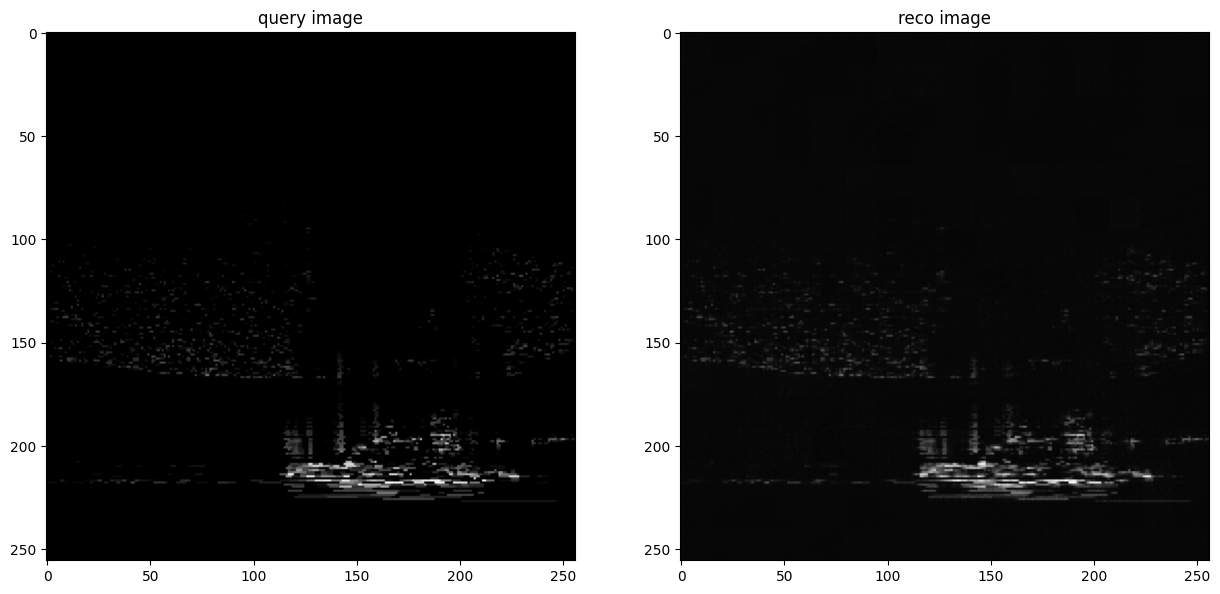

In [41]:
visualizer.analyze_feature_robustness(train_data, net)

dist matrix tensor([1.0897, 1.0897, 1.0897, 1.0897, 1.0897])
cand tensor([308.7029, 278.7029, 338.7029, 293.7029, 323.7029])
yaw_deg 310.63087463378906
diff yaw tensor([ 1.9280, 31.9280, 28.0721, 16.9280, 13.0721])
iou: 0.07323944387805008
localization error: 7.7015 meters
orientation error : 51.3639 degrees


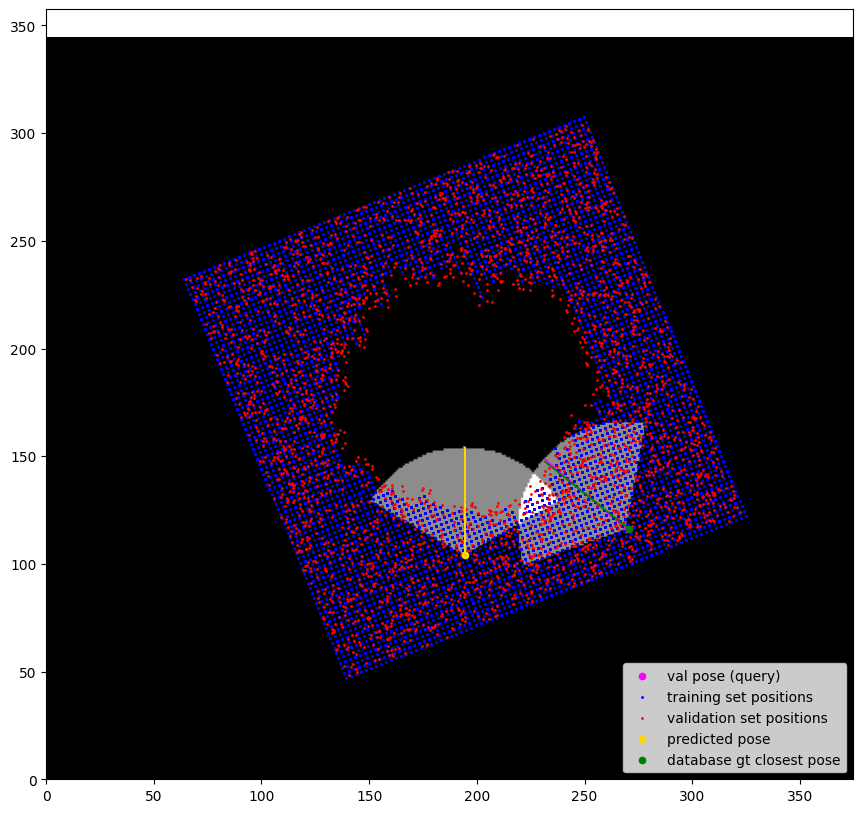

<Figure size 640x480 with 0 Axes>

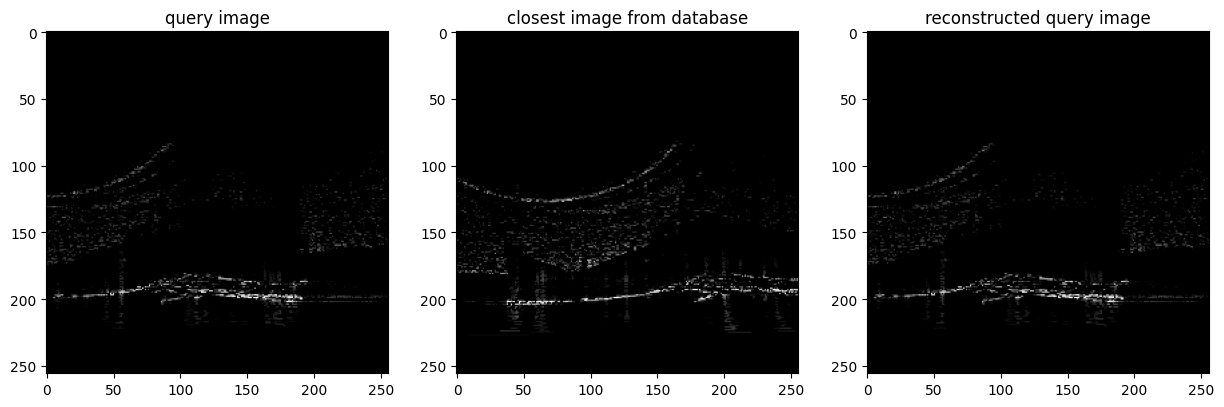

In [42]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [43]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  0%|                                          | 7/3269 [00:00<01:39, 32.78it/s]

dist matrix tensor([4.3157, 4.3157, 4.3157, 4.3157, 4.3157])
cand tensor([ 20.7047,   5.7047, 350.7047, 335.7047, 320.7047])
yaw_deg 347.1947555541992
diff yaw tensor([33.5099, 18.5099,  3.5099, 11.4901, 26.4901])
dist matrix tensor([0.9843, 0.9843, 0.9843, 0.9843, 0.9843])
cand tensor([304.7783, 319.7783, 289.7783, 274.7783, 259.7783])
yaw_deg 305.48915100097656
diff yaw tensor([ 0.7109, 14.2891, 15.7109, 30.7109, 45.7109])
dist matrix tensor([0.4677, 0.4677, 0.4677, 0.4677, 0.4677])
cand tensor([122.1898, 167.1898, 152.1898, 137.1898, 182.1898])
yaw_deg 158.6386260986328
diff yaw tensor([36.4488,  8.5512,  6.4488, 21.4488, 23.5512])
dist matrix tensor([4.9497, 4.9497, 4.9497, 4.9497, 4.9497])
cand tensor([ 78.0013, 108.0013, 123.0013,  93.0013, 138.0013])
yaw_deg 116.80926895141602
diff yaw tensor([38.8080,  8.8080,  6.1920, 23.8080, 21.1920])
dist matrix tensor([1.1524, 1.1524, 1.1524, 1.1524, 1.1524])
cand tensor([ 86.2411, 101.2411, 116.2411, 131.2411,  71.2411])
yaw_deg 118.42214

  0%|▏                                        | 11/3269 [00:00<02:37, 20.64it/s]

dist matrix tensor([1.2374, 1.2374, 1.2374, 1.2374, 1.2374])
cand tensor([234.2976, 189.2976, 174.2976, 204.2976, 219.2976])
yaw_deg 223.08262634277344
diff yaw tensor([11.2149, 33.7850, 48.7850, 18.7850,  3.7851])
dist matrix tensor([0.3750, 0.3750, 0.3750, 0.3750, 0.3750])
cand tensor([234.4048, 219.4048, 204.4048, 249.4048, 189.4048])
yaw_deg 244.3869171142578
diff yaw tensor([ 9.9822, 24.9822, 39.9822,  5.0178, 54.9822])
dist matrix tensor([1.3607, 1.3607, 1.3607, 1.3607, 1.3607])
cand tensor([ 47.3627, 107.3627,  92.3627,  62.3627,  77.3627])
yaw_deg 90.00744845112786
diff yaw tensor([42.6447, 17.3553,  2.3553, 27.6447, 12.6447])
dist matrix tensor([0.6960, 0.6960, 0.6960, 0.6960, 0.6960])
cand tensor([ 12.7995,  57.7995,  42.7995,  27.7995, 357.7995])
yaw_deg 54.360877990722656
diff yaw tensor([41.5614,  3.4386, 11.5614, 26.5614, 56.5614])
dist matrix tensor([0.6847, 0.6847, 0.6847, 0.6847, 0.6847])
cand tensor([226.0990, 241.0990, 211.0990, 196.0990, 256.0990])
yaw_deg 230.60842

  1%|▎                                        | 20/3269 [00:00<01:48, 29.82it/s]

dist matrix tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500])
cand tensor([319.3240, 274.3240, 289.3240, 304.3240, 259.3240])
yaw_deg 317.3241729736328
diff yaw tensor([ 1.9999, 43.0001, 28.0001, 13.0001, 58.0001])
dist matrix tensor([0.7706, 0.7706, 0.7706, 0.7706, 0.7706])
cand tensor([65.0217, 35.0217, 50.0217, 80.0217, 20.0217])
yaw_deg 53.558738708496094
diff yaw tensor([11.4630, 18.5370,  3.5370, 26.4630, 33.5370])
dist matrix tensor([0.8570, 0.8570, 0.8570, 0.8570, 0.8570])
cand tensor([194.3696, 164.3696, 209.3696, 179.3696, 224.3696])
yaw_deg 212.0159454345703
diff yaw tensor([17.6463, 47.6463,  2.6463, 32.6463, 12.3537])
dist matrix tensor([1.1456, 1.1456, 1.1456, 1.1456, 1.1456])
cand tensor([339.5370, 309.5370,   9.5370, 354.5370, 324.5370])
yaw_deg 343.7386779785156
diff yaw tensor([ 4.2017, 34.2017, 25.7983, 10.7983, 19.2017])
dist matrix tensor([0.6374, 0.6374, 0.6374, 0.6374, 0.6374])
cand tensor([230.6098, 185.6098, 215.6098, 170.6098, 200.6098])
yaw_deg 212.63531494140

  1%|▎                                        | 28/3269 [00:00<01:37, 33.13it/s]

dist matrix tensor([0.9354, 0.9354, 0.9354, 0.9354, 0.9354])
cand tensor([280.0215, 265.0215, 235.0215, 250.0215, 220.0215])
yaw_deg 271.3812561035156
diff yaw tensor([ 8.6402,  6.3598, 36.3598, 21.3598, 51.3598])
dist matrix tensor([0.9437, 0.9437, 0.9437, 0.9437, 0.9437])
cand tensor([13.6726, 73.6726, 58.6726, 28.6726, 43.6726])
yaw_deg 43.205963134765625
diff yaw tensor([29.5333, 30.4667, 15.4667, 14.5333,  0.4667])
dist matrix tensor([1.0078, 1.0078, 1.0078, 1.0078, 1.0078])
cand tensor([140.8950, 110.8950, 155.8950, 125.8950,  95.8950])
yaw_deg 146.26158905029297
diff yaw tensor([ 5.3666, 35.3666,  9.6334, 20.3666, 50.3666])
dist matrix tensor([0.6673, 0.6673, 0.6673, 0.6673, 0.6673])
cand tensor([ 48.0013,   3.0013,  18.0013, 348.0013,  33.0013])
yaw_deg 28.30218505859375
diff yaw tensor([19.6991, 25.3009, 10.3009, 40.3009,  4.6991])
dist matrix tensor([1.1285, 1.1285, 1.1285, 1.1285, 1.1285])
cand tensor([116.5918, 146.5918,  86.5918, 101.5918, 131.5918])
yaw_deg 146.0495948791

  1%|▍                                        | 37/3269 [00:01<01:32, 35.07it/s]

dist matrix tensor([1.2295, 1.2295, 1.2295, 1.2295, 1.2295])
cand tensor([58.4381, 28.4381, 88.4381, 43.4381, 73.4381])
yaw_deg 82.88558292388916
diff yaw tensor([24.4475, 54.4475,  5.5525, 39.4475,  9.4475])
dist matrix tensor([1.2247, 1.2247, 1.2247, 1.2247, 1.2247])
cand tensor([246.5108, 216.5108, 231.5108, 201.5108, 261.5109])
yaw_deg 244.8418426513672
diff yaw tensor([ 1.6690, 28.3310, 13.3310, 43.3310, 16.6690])
dist matrix tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500])
cand tensor([156.0344, 201.0344, 141.0344, 171.0344, 186.0344])
yaw_deg 171.30958557128906
diff yaw tensor([15.2752, 29.7248, 30.2752,  0.2752, 14.7248])
dist matrix tensor([1.4443, 1.4443, 1.4443, 1.4443, 1.4443])
cand tensor([307.9004, 352.9004,   7.9004, 337.9004, 322.9004])
yaw_deg 341.5683135986328
diff yaw tensor([33.6679, 11.3321, 26.3321,  3.6679, 18.6679])
dist matrix tensor([1.0533, 1.0533, 1.0533, 1.0533, 1.0533])
cand tensor([330.0254, 315.0254, 300.0254, 285.0254, 270.0254])
yaw_deg 326.07438659667

  1%|▌                                        | 45/3269 [00:01<01:40, 32.02it/s]

dist matrix tensor([0.9228, 0.9228, 0.9228, 0.9228, 0.9228])
cand tensor([ 91.8629, 106.8629,  61.8629,  76.8629, 121.8629])
yaw_deg 94.95837688446045
diff yaw tensor([ 3.0955, 11.9045, 33.0955, 18.0955, 26.9045])
dist matrix tensor([1.0897, 1.0897, 1.0897, 1.0897, 1.0897])
cand tensor([212.4676, 152.4676, 182.4676, 167.4676, 197.4676])
yaw_deg 187.90531158447266
diff yaw tensor([24.5623, 35.4377,  5.4377, 20.4377,  9.5623])
dist matrix tensor([1.1319, 1.1319, 1.1319, 1.1319, 1.1319])
cand tensor([190.6451, 205.6451, 160.6451, 145.6451, 175.6451])
yaw_deg 178.79756927490234
diff yaw tensor([11.8475, 26.8475, 18.1525, 33.1525,  3.1525])
dist matrix tensor([1.1180, 1.1180, 1.1180, 1.1180, 1.1180])
cand tensor([176.8250, 206.8250, 146.8250, 161.8250, 191.8250])
yaw_deg 186.44312286376953
diff yaw tensor([ 9.6181, 20.3819, 39.6181, 24.6181,  5.3819])
dist matrix tensor([0.9479, 0.9479, 0.9479, 0.9479, 0.9479])
cand tensor([28.7548, 13.7548, 73.7548, 58.7548, 43.7548])
yaw_deg 50.3415794372

KeyboardInterrupt: 

In [44]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [45]:
loca_errors.argmax()

np.int64(36)

In [46]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

4.7025514
27.03992


## process real images

query_idx: 433
266.47003 204.79004 1.5895678 -88.92448
iou: 0.0
localization error Upper:  10.852255 meters


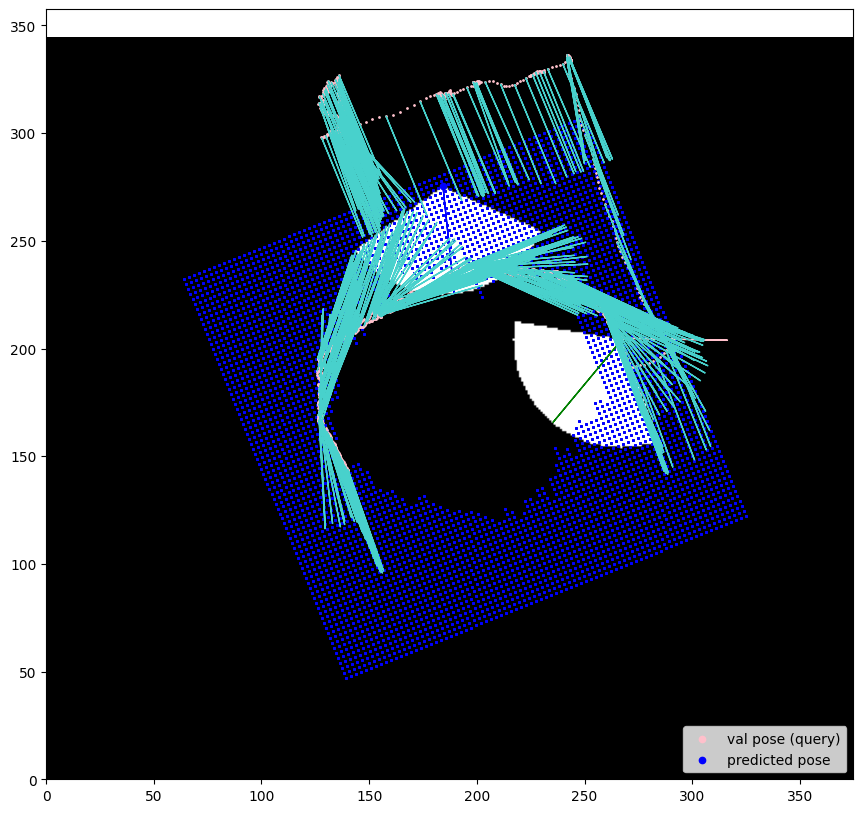

<Figure size 640x480 with 0 Axes>

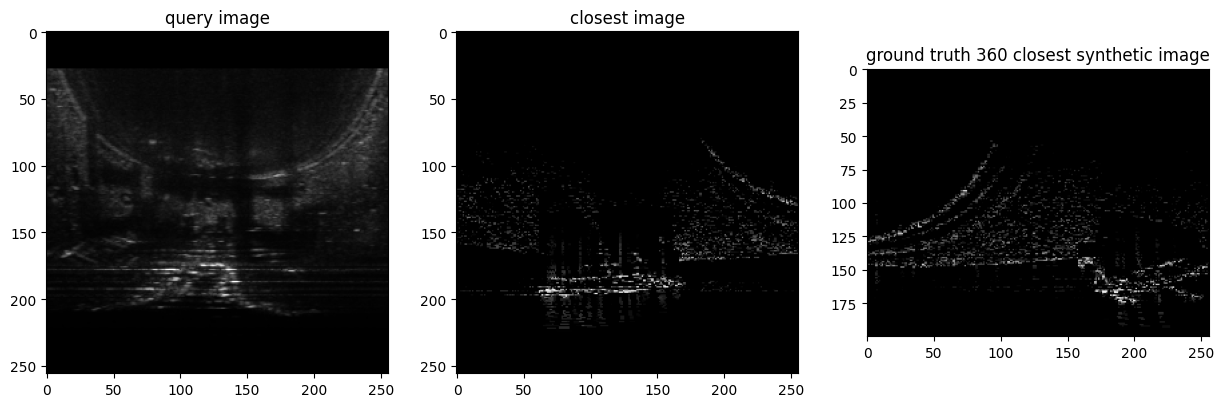

In [48]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [52]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [53]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


 14%|█████▋                                    | 97/710 [00:01<00:07, 85.46it/s]


KeyboardInterrupt: 

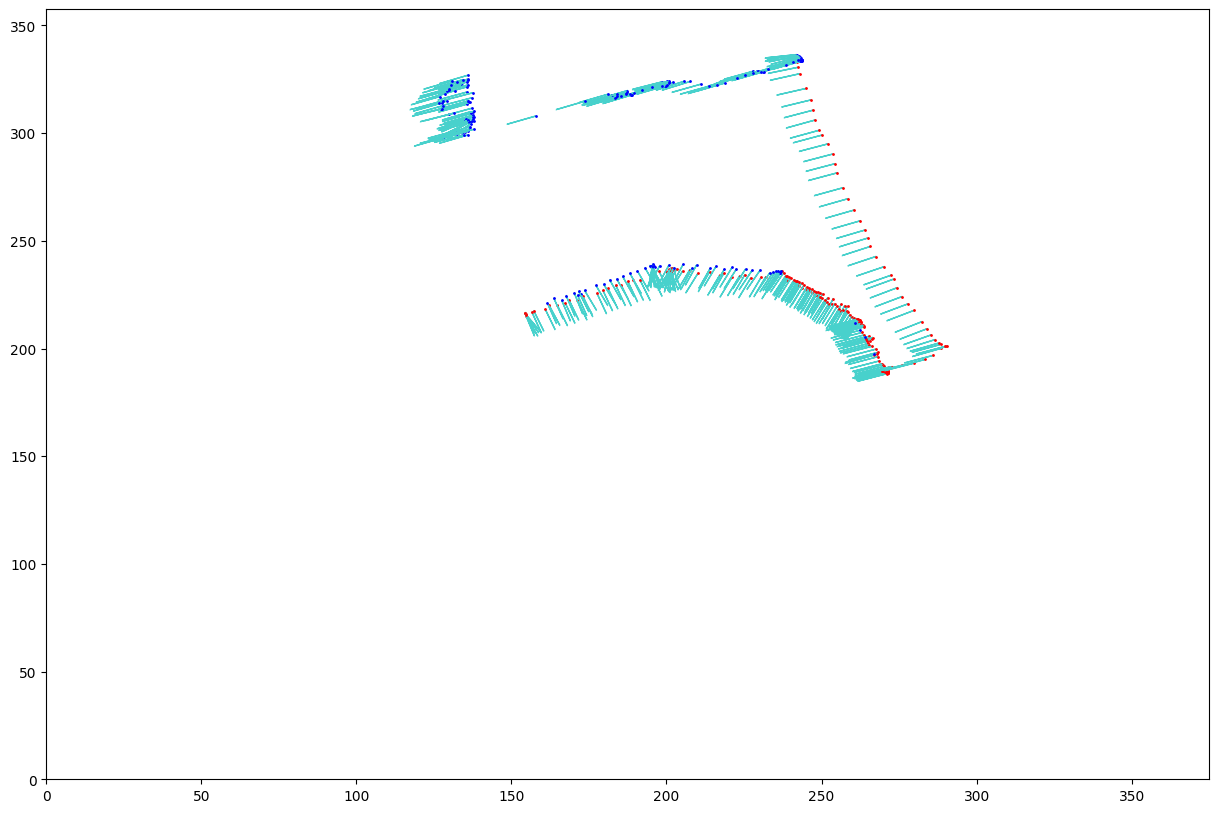

In [54]:
visualizer.visualize_real(train_data, real_data)

iou: 0.5982357782810704
localization error: 1.9370 meters
orientation error : 0.0917 degrees


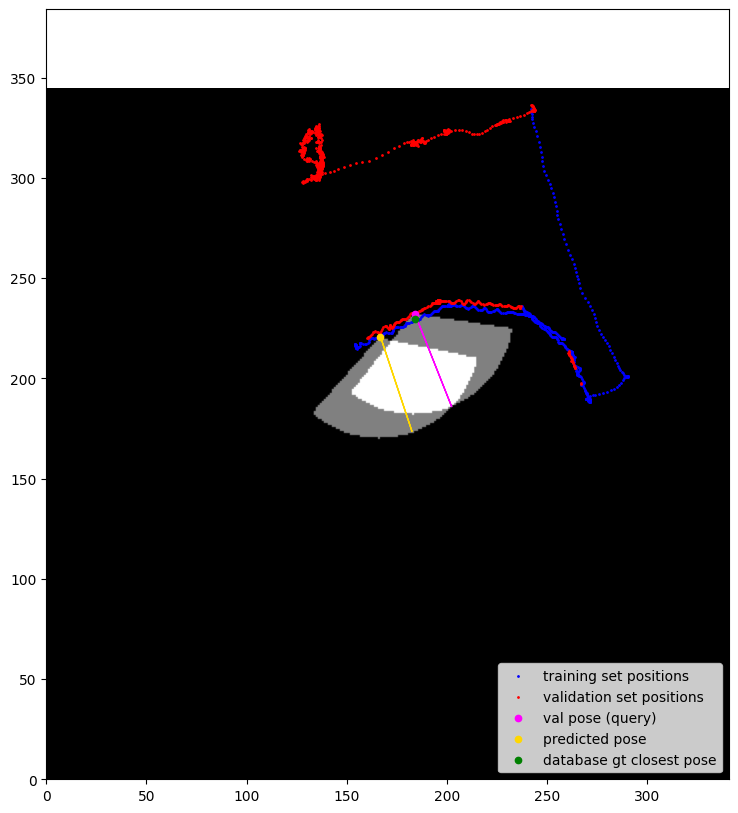

<Figure size 640x480 with 0 Axes>

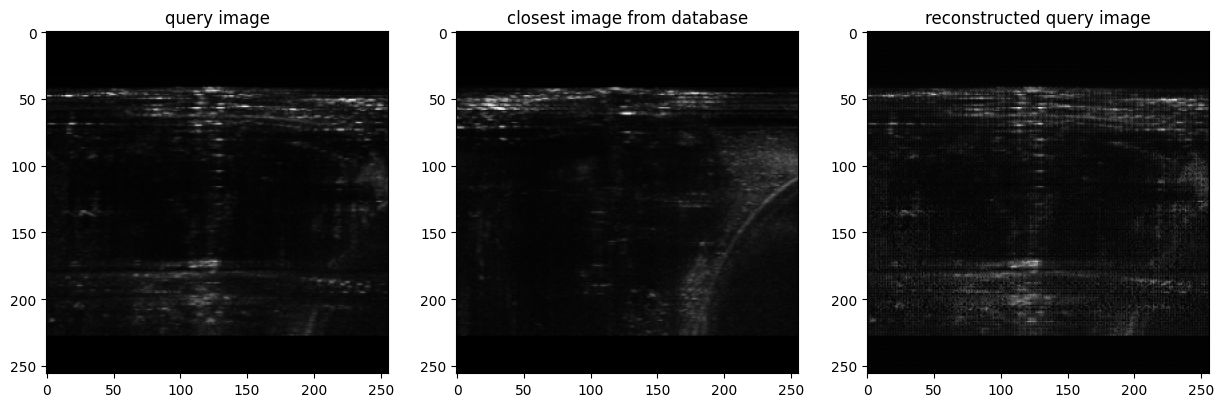

In [55]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [56]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

  8%|███▎                                      | 62/785 [00:01<00:17, 40.62it/s]


KeyboardInterrupt: 

In [57]:
avg_orie_error.min()

NameError: name 'avg_orie_error' is not defined